<div dir="rtl" align="right">

# بخش اول: بارگذاری کتابخانه‌ها و تنظیمات اولیه

این بخش شامل بارگذاری کتابخانه‌های مورد نیاز، تنظیمات پایه، و بررسی کتابخانه‌های خاص است. این مرحله برای آماده‌سازی محیط اجرای کد ضروری است.

---

## 1. **بارگذاری کتابخانه‌های اصلی**

### توضیحات درباره کتابخانه‌ها:
- **`os`**:
  - برای مدیریت مسیرها و دسترسی به فایل‌ها و دایرکتوری‌ها استفاده می‌شود.
- **`random`**:
  - برای انجام عملیات تصادفی مانند ایجاد نویز یا انتخاب تصادفی داده‌ها استفاده می‌شود.
- **`json`**:
  - برای ذخیره‌سازی و بارگذاری داده‌ها در قالب JSON (مانند تاریخچه آموزش مدل) استفاده می‌شود.
- **`numpy`**:
  - کتابخانه‌ای برای انجام محاسبات عددی با کارایی بالا روی آرایه‌ها.
- **`librosa`**:
  - کتابخانه‌ای قدرتمند برای پردازش صوت، مانند استخراج ویژگی‌ها.
- **`matplotlib.pyplot` و `seaborn`**:
  - برای رسم نمودارها و مصورسازی داده‌ها استفاده می‌شوند.

---

## 2. **بارگذاری کتابخانه‌های یادگیری عمیق و پردازش داده**

### کتابخانه‌های استفاده‌شده:
- **`skimage.transform.resize`**:
  - برای تغییر اندازه تصاویر و داده‌های ورودی به ابعاد مشخص استفاده می‌شود.
- **`sklearn.model_selection.train_test_split`**:
  - برای تقسیم داده‌ها به مجموعه آموزش و آزمون.
- **`sklearn.metrics`**:
  - برای محاسبه متریک‌هایی مانند ماتریس درهم‌ریختگی و گزارش دسته‌بندی.

---

## 3. **بررسی کتابخانه spafe**

- **هدف**:
  - این کتابخانه برای استخراج ویژگی‌های LPC (Linear Predictive Coding) استفاده می‌شود.
- **بررسی نصب بودن spafe**:
  - در صورتی که کتابخانه نصب نشده باشد، پیام خطا نمایش داده و برنامه متوقف می‌شود:
    ```python
    try:
        from spafe.features.lpc import lpc
    except ImportError:
        print("[ERROR] spafe library not installed. Please install via: pip install spafe")
        exit(1)
    ```

---

## 4. **بارگذاری کتابخانه‌های TensorFlow**

### استفاده‌های اصلی:
- **لایه‌های مدل (Layers)**:
  - لایه‌هایی مانند Conv2D، MaxPool2D، Flatten، Dense و Dropout برای ساخت مدل‌های یادگیری عمیق.
- **ابزارهای پیش‌پردازش داده (Utilities)**:
  - `to_categorical`: تبدیل برچسب‌ها به قالب one-hot.
- **بهینه‌سازی (Optimizers)**:
  - `Adam`: یکی از الگوریتم‌های بهینه‌سازی معروف برای تنظیم وزن‌های شبکه.

---

## نتیجه:
- تمامی کتابخانه‌های ضروری برای انجام پردازش صوت، استخراج ویژگی، و ساخت مدل یادگیری عمیق آماده استفاده هستند.
- در ادامه، تنظیمات مربوط به CPU/GPU و متغیرهای مرتبط با دیتاست معرفی خواهند شد.

</div>


In [ ]:

import os
import random
import json
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# --- spafe برای استخراج LPC ---
try:
    from spafe.features.lpc import lpc
except ImportError:
    print("[ERROR] spafe library not installed. Please install via: pip install spafe")
    exit(1)

from tensorflow.keras.layers import (Conv2D, MaxPool2D, Flatten, Dense,
                                     Dropout, Activation)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import tensorflow as tf


[ERROR] spafe library not installed. Please install via: pip install spafe


In [ ]:

# ========================================
# 1. تنظیم منابع (CPU/GPU) با تعداد Threads
# ========================================
num_threads = 50
tf.config.threading.set_intra_op_parallelism_threads(num_threads)
tf.config.threading.set_inter_op_parallelism_threads(num_threads)

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("[INFO] GPU memory growth enabled.")
        print("[INFO] Running on GPU:", physical_devices[0])
    except Exception as e:
        print("[WARNING] Could not set GPU memory growth:", e)
else:
    print(f"[INFO] No accessible GPU found; using CPU with {num_threads} threads.")


[INFO] GPU memory growth enabled.
[INFO] Running on GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


<div dir="rtl" align="right">

# تعریف پارامترهای کلیدی برای پردازش داده‌های صوتی

این پارامترها برای کنترل فرآیند پردازش و استخراج ویژگی‌ها از چانک‌های صوتی تعریف شده‌اند. هر کدام نقش مهمی در تقسیم‌بندی، تحلیل، و آماده‌سازی داده‌ها ایفا می‌کنند.

---

## 1. **`CHUNK_DURATION`**
- **تعریف**:
  - مدت زمان هر چانک صوتی که از فایل اصلی برش داده می‌شود.
- **مقدار**: `4.0` (بر حسب ثانیه)
- **جزئیات**:
  - هر فایل صوتی به بخش‌هایی با این طول تقسیم می‌شود.
  - مقدار مناسب این پارامتر به پیچیدگی سیگنال صوتی و نوع ویژگی‌های موردنظر بستگی دارد.
- **مثال**:
  - اگر یک فایل صوتی 10 ثانیه‌ای داشته باشیم و مدت زمان چانک 4 ثانیه باشد، فایل به تقریباً 3 بخش تقسیم خواهد شد (با در نظر گرفتن همپوشانی).

---

## 2. **`OVERLAP_DURATION`**
- **تعریف**:
  - مدت زمان همپوشانی بین چانک‌های متوالی.
- **مقدار**: `2.0` (بر حسب ثانیه)
- **جزئیات**:
  - همپوشانی به جلوگیری از از دست رفتن اطلاعات صوتی بین چانک‌ها کمک می‌کند.
  - مقدار مناسب همپوشانی به نوع سیگنال و نیازهای مدل بستگی دارد.
- **مثال**:
  - اگر مدت زمان چانک 4 ثانیه و همپوشانی 2 ثانیه باشد، چانک دوم از ثانیه دوم چانک اول آغاز می‌شود.

---

## 3. **`TARGET_SHAPE`**
- **تعریف**:
  - ابعاد نهایی ویژگی‌ها پس از تغییر اندازه (رزولوشن).
- **مقدار**: `(150, 150)`
  - ارتفاع: `150`
  - عرض: `150`
- **جزئیات**:
  - این ابعاد برای سازگاری داده‌های ورودی با شبکه یادگیری عمیق تنظیم می‌شوند.
  - ابعاد کوچکتر زمان پردازش را کاهش می‌دهند، اما ممکن است دقت ویژگی‌ها کاهش یابد.
- **مثال**:
  - یک ماتریس با اندازه `(150, 150)` به مدل ورودی داده می‌شود.

---

## 4. **`LPC_ORDER`**
- **تعریف**:
  - مرتبه ضرایب **LPC** (Linear Predictive Coding) که برای هر فریم محاسبه می‌شوند.
- **مقدار**: `12`
- **جزئیات**:
  - این مقدار تعداد ضرایب پیش‌بینی‌کننده خطی را مشخص می‌کند.
  - طبق پیاده‌سازی spafe، تعداد ضرایب خروجی برابر است با `LPC_ORDER + 1`.
- **اهمیت**:
  - ضرایب LPC ویژگی‌هایی از سیگنال را ارائه می‌دهند که برای تحلیل گفتار و موسیقی بسیار مهم هستند.
- **مثال**:
  - برای `LPC_ORDER = 12`، هر فریم صوتی شامل 13 ضرایب LPC خواهد بود.

---

### خلاصه:
- **`CHUNK_DURATION`** و **`OVERLAP_DURATION`** مسئول تقسیم‌بندی فایل صوتی به چانک‌های کوچک‌تر هستند.
- **`TARGET_SHAPE`** ابعاد داده‌ها را برای مدل یادگیری عمیق تنظیم می‌کند.
- **`LPC_ORDER`** تعداد ضرایب LPC را که نشان‌دهنده ویژگی‌های کلیدی سیگنال صوتی هستند، تعیین می‌کند.

</div>


In [ ]:

# ================================
# 2. پارامترهای مربوط به دیتاست
# ================================
from google.colab import drive
drive.mount('/content/drive')


folder_path = '/content/drive/My Drive/yadgiri/Music Genre Classification System'
for file_name in os.listdir(folder_path):
    print(file_name)


DATA_DIR = "/content/drive/My Drive/yadgiri/Music Genre Classification System/Data/genres_original"  # پوشه‌ی اصلی که ژانرها در زیرشاخه‌های آن هستند
CLASSES = ['blues', 'classical','country','disco','hiphop',
           'jazz','metal','pop','reggae','rock']

CHUNK_DURATION   = 4.0  # طول هر چانک (ثانیه)
OVERLAP_DURATION = 2.0  # همپوشانی (ثانیه)
TARGET_SHAPE     = (150, 150)  # اندازهٔ نهایی ویژگی (ارتفاع=150، عرض=150)
LPC_ORDER        = 23   # مرتبهٔ LPC
# (تعداد ضرایب LPC خروجی، طبق پیاده‌سازی spafe، می‌شود order+1 در هر فریم)


Mounted at /content/drive
Trained_model.h5
temp_audio_file.mp3
Data
test_music


<div dir="rtl" align="right">

# تابع `cmvn`: نرمال‌سازی میانگین و واریانس کپسترال (CMVN)

این تابع برای بهبود کیفیت داده‌های صوتی و حذف اثرات ناشی از تغییرات شدت صدا و نویز محیطی استفاده می‌شود. با اعمال **نرمال‌سازی میانگین و واریانس** روی ضرایب ویژگی‌های صوتی، داده‌ها یکنواخت‌تر و پایدارتر می‌شوند.

---

## عملکرد تابع `cmvn`

- **ورودی**:
  - **`feature_array`**:
    - ماتریس ویژگی‌های صوتی با ابعاد `(num_features, time_frames)`.
    - شامل ضرایب ویژگی‌هایی مانند MFCC یا LPC در طول زمان.

- **خروجی**:
  - ماتریس نرمال‌سازی‌شده با همان ابعاد ورودی.

---

## مراحل اجرا

1. **محاسبه میانگین ضرایب**:
   - میانگین مقادیر هر ویژگی در طول زمان محاسبه می‌شود:
     ```python
     mean = feature_array.mean(axis=1, keepdims=True)
     ```
   - **ابعاد**:
     - `mean` دارای ابعادی به شکل `(num_features, 1)` است.

2. **محاسبه انحراف معیار ضرایب**:
   - انحراف معیار هر ویژگی در طول زمان محاسبه می‌شود:
     ```python
     std = feature_array.std(axis=1, keepdims=True) + 1e-9
     ```
   - **اضافه کردن مقدار کوچک (`1e-9`)**:
     - برای جلوگیری از تقسیم بر صفر در هنگام نرمال‌سازی.

3. **اعمال نرمال‌سازی**:
   - هر مقدار در ماتریس ورودی با فرمول زیر نرمال‌سازی می‌شود:
     ```python
     normalized_features = (feature_array - mean) / std
     ```
   - این فرآیند داده‌ها را با میانگین صفر و واریانس یک استاندارد می‌کند.

---

## اهمیت و مزایا

- **حذف تغییرات شدت صدا**:
  - تغییرات در شدت ضبط صوت یا نویز محیطی بر ضرایب نرمال‌سازی‌شده تأثیر نمی‌گذارد.
- **بهبود پایداری مدل**:
  - مدل‌های یادگیری عمیق نسبت به داده‌های نرمال‌شده دقت بالاتری دارند.
- **تطبیق بهتر در محیط‌های مختلف**:
  - CMVN داده‌ها را مستقل از شرایط ضبط (مانند میکروفون یا محیط) می‌کند.

---

### مثال استفاده:
```python
# فرض کنید feature_array دارای شکل (13, 100) باشد
normalized_features = cmvn(feature_array)
print(normalized_features.shape)  # خروجی: (13, 100)
</div> ```

In [ ]:



# ========================================
# 3. توابع کمکی برای پردازش و Augmentation
# ========================================
def cmvn(feature_array):
    """
    اعمال Cepstral Mean and Variance Normalization (CMVN)
    روی ماتریس ورودی: شکل (num_features, time_frames).
    """
    mean = feature_array.mean(axis=1, keepdims=True)
    std  = feature_array.std(axis=1, keepdims=True) + 1e-9
    return (feature_array - mean) / std

<div dir="rtl" align="right">

# توضیح تابع `phase_vocoder_time_stretch`

### معرفی:
این تابع برای تغییر طول زمانی سیگنال صوتی طراحی شده است. با استفاده از تکنیک **Phase Vocoder**، سیگنال کشیده یا فشرده می‌شود، بدون اینکه فرکانس یا گام صدا تغییر کند. این فرآیند با استفاده از تبدیل فوریه کوتاه‌مدت (STFT) و تبدیل معکوس آن (iSTFT) انجام می‌شود.

---

## عملکرد تابع

### ورودی‌ها:
1. **`y`**:
   - سیگنال صوتی ورودی به صورت آرایه‌ای یک‌بعدی.
   - نوع داده: `numpy array`
   - شامل نمونه‌های زمانی سیگنال صوتی است.

2. **`rate`**:
   - نسبت کشش زمانی.
   - نوع داده: `float`
   - مقدار پیش‌فرض: `1.0` (بدون تغییر).
   - **مقادیر ممکن**:
     - `rate > 1.0`: کشیده شدن سیگنال (زمان طولانی‌تر).
     - `rate < 1.0`: فشرده شدن سیگنال (زمان کوتاه‌تر).

### خروجی:
- سیگنال کشیده‌شده یا فشرده‌شده.
- نوع داده: `numpy array` (همان نوع ورودی).

---

## مراحل اجرا

1. **بررسی مقدار `rate`**:
   - اگر مقدار `rate` برابر با `1.0` باشد، هیچ تغییری اعمال نشده و سیگنال اصلی بازگردانده می‌شود:
     ```python
     if rate == 1.0:
         return y  # بدون تغییر
     ```

2. **تبدیل به حوزه فرکانس-زمان**:
   - سیگنال با استفاده از تبدیل فوریه کوتاه‌مدت (STFT) به حوزه فرکانس-زمان منتقل می‌شود:
     ```python
     D = librosa.stft(y, n_fft=2048, hop_length=512)
     ```
   - **`n_fft`**:
     - تعداد نقاط برای محاسبه تبدیل فوریه (FFT).
   - **`hop_length`**:
     - فاصله بین فریم‌های متوالی برای تجزیه سیگنال.

3. **اعمال کشش زمانی**:
   - با استفاده از Phase Vocoder، کشش زمانی اعمال می‌شود:
     ```python
     D_stretched = librosa.phase_vocoder(D, rate=rate, hop_length=512)
     ```
   - **`rate`**:
     - مقدار بالاتر از 1.0 باعث کشیدگی زمانی می‌شود.
     - مقدار کمتر از 1.0 باعث فشردگی زمانی می‌شود.

4. **بازگشت به حوزه زمان**:
   - سیگنال کشیده‌شده با استفاده از تبدیل معکوس (iSTFT) به حوزه زمان بازگردانده می‌شود:
     ```python
     y_stretched = librosa.istft(D_stretched, hop_length=512)
     return y_stretched
     ```

---

## اهمیت و مزایا

1. **حفظ فرکانس و گام صدا**:
   - برخلاف تغییر سرعت ساده، این روش گام یا فرکانس اصلی سیگنال را ثابت نگه می‌دارد.
   
2. **کاربردها**:
   - تغییر زمان موسیقی یا گفتار برای تنظیمات خاص.
   - تحلیل دقیق ویژگی‌های صوتی.

---

### مثال استفاده

```python
# بارگذاری سیگنال صوتی
y, sr = librosa.load("audio.wav", sr=None)

# کشش زمانی سیگنال با نسبت 1.5
y_stretched = phase_vocoder_time_stretch(y, rate=1.5)

# ذخیره سیگنال کشیده‌شده
librosa.output.write_wav("stretched_audio.wav", y_stretched, sr=sr)
```
</div>

In [ ]:

def phase_vocoder_time_stretch(y, rate=1.0):
    """
    کشش زمانی سیگنال موج با استفاده از فاز-ووکدر librosa:
    1) محاسبه STFT
    2) اعمال phase_vocoder
    3) بازگشت به حوزهٔ زمانی با iSTFT
    """
    if rate == 1.0:
        return y  # بدون تغییر

    # تبدیل سیگنال خام به فرکانس-زمان
    D = librosa.stft(y, n_fft=2048, hop_length=512)
    # کشش زمانی
    D_stretched = librosa.phase_vocoder(D, rate=rate, hop_length=512)
    # بازگشت به حوزهٔ زمان
    y_stretched = librosa.istft(D_stretched, hop_length=512)
    return y_stretched

<div dir="rtl" align="right">

# توضیح تابع `augment_audio`

### معرفی:
این تابع به منظور انجام **افزایش داده‌ها (Data Augmentation)** روی سیگنال‌های صوتی طراحی شده است. با استفاده از تغییراتی تصادفی مانند افزودن نویز، تغییر گام (Pitch Shift) و کشش زمانی (Time Stretch)، تنوع داده‌های صوتی افزایش می‌یابد و در نتیجه مدل یادگیری عمیق مقاوم‌تر و عمومی‌تر می‌شود.

---

## عملکرد تابع

### ورودی‌ها:
1. **`y`**:
   - سیگنال صوتی ورودی.
   - نوع داده: `numpy array` (یک‌بعدی).
   - شامل نمونه‌های زمانی سیگنال صوتی است.

2. **`sr`**:
   - نرخ نمونه‌برداری سیگنال صوتی.
   - نوع داده: `int`

3. **`p`**:
   - احتمال اعمال تغییرات.
   - نوع داده: `float`
   - مقدار پیش‌فرض: `0.5`

---

### مراحل اجرا

1. **تبدیل داده‌ها به نوع `float`**:
   - بررسی می‌شود که سیگنال ورودی از نوع شناور (float) باشد. در غیر این صورت، به نوع `float32` تبدیل می‌شود:
     ```python
     if not np.issubdtype(y.dtype, np.floating):
         y = y.astype(np.float32)
     ```

2. **بررسی احتمال تغییرات**:
   - اگر عدد تصادفی تولید شده بزرگ‌تر از مقدار `p` باشد، هیچ تغییری روی سیگنال اعمال نشده و سیگنال اصلی بازگردانده می‌شود:
     ```python
     if random.random() > p:
         return y
     ```

3. **افزودن نویز تصادفی (Random Noise)**:
   - با احتمال 0.3، نویز تصادفی به سیگنال اضافه می‌شود:
     ```python
     if random.random() < 0.3:
         noise_amp = 0.005 * np.random.uniform() * np.amax(y)
         y = y + noise_amp * np.random.normal(size=len(y))
     ```

4. **تغییر گام (Pitch Shift)**:
   - با احتمال 0.3، گام سیگنال در بازه‌ای بین `-2` تا `+2` نیم‌پرده تغییر می‌کند:
     ```python
     if random.random() < 0.3:
         n_steps = np.random.uniform(-2, 2)
         y = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=n_steps)
     ```

5. **کشش زمانی (Time Stretch)**:
   - با احتمال 0.3، کشش زمانی سیگنال در بازه‌ای بین `0.8` تا `1.2` اعمال می‌شود:
     ```python
     if random.random() < 0.3:
         rate = np.random.uniform(0.8, 1.2)
         y = phase_vocoder_time_stretch(y, rate=rate)
     ```

---

## خروجی:
- سیگنال صوتی پس از اعمال تغییرات.
- نوع داده: `numpy array`

---

## اهمیت و مزایا

1. **افزایش تنوع داده‌ها**:
   - با اعمال تغییرات تصادفی، مدل می‌تواند روی داده‌های متنوع‌تری آموزش ببیند.

2. **کاهش بیش‌برازش (Overfitting)**:
   - تنوع بیشتر داده‌ها به مدل کمک می‌کند تا بهتر تعمیم یابد.

3. **شبیه‌سازی سناریوهای واقعی**:
   - تغییراتی مانند نویز و کشش زمانی شرایط واقعی ضبط صوت را شبیه‌سازی می‌کنند.

---

### مثال استفاده:

```python
# بارگذاری سیگنال صوتی
y, sr = librosa.load("audio.wav", sr=None)

# اعمال تغییرات تصادفی روی سیگنال
y_augmented = augment_audio(y, sr, p=0.5)

# ذخیره سیگنال تغییر یافته
librosa.output.write_wav("augmented_audio.wav", y_augmented, sr=sr)
```
</div>

In [ ]:

def augment_audio(y, sr, p=0.5):
    """
    با احتمال p، اعمالی مانند نویز، Pitch Shift و Time Stretch
    روی سیگنال y به‌صورت تصادفی اعمال می‌شود.
    اینجا از فاز-ووکدر librosa برای کشش زمانی استفاده می‌کنیم.
    """
    import random

    # اطمینان از اینکه y نوع float دارد
    if not np.issubdtype(y.dtype, np.floating):
        y = y.astype(np.float32)

    if random.random() > p:
        return y  # بدون تغییر

    # 1. افزودن نویز تصادفی با احتمال 0.3
    if random.random() < 0.3:
        noise_amp = 0.005 * np.random.uniform() * np.amax(y)
        y = y + noise_amp * np.random.normal(size=len(y))

    # 2. تغییر گام (Pitch Shift) با احتمال 0.3
    if random.random() < 0.3:
        n_steps = np.random.uniform(-2, 2)  # ممکن است بین -2 تا +2 نیم‌پرده
        y = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=n_steps)

    # 3. تغییر سرعت پخش (Time Stretch) با احتمال 0.3
    if random.random() < 0.3:
        rate = np.random.uniform(0.8, 1.2)
        y = phase_vocoder_time_stretch(y, rate=rate)

    return y

<div dir="rtl" align="right">

# توضیح تابع `extract_lpc_features` - بخش اول

### معرفی:
این تابع وظیفه استخراج **ویژگی‌های LPC (Linear Predictive Coding)** از سیگنال‌های صوتی را برعهده دارد. ویژگی‌های LPC به منظور تحلیل و مدل‌سازی سیگنال‌های صوتی، به‌ویژه در کاربردهایی مثل فشرده‌سازی و تشخیص گفتار، استفاده می‌شوند. علاوه بر LPC، مشتقات دلتا و دلتا-دلتا نیز برای افزایش دقت استخراج می‌شوند.

---

## ورودی‌ها:
1. **`chunk`**:
   - سیگنال صوتی ورودی.
   - نوع داده: `numpy array` (یک‌بعدی).
   - شامل نمونه‌های زمانی سیگنال صوتی است.

2. **`sr`**:
   - نرخ نمونه‌برداری سیگنال صوتی.
   - نوع داده: `int`

3. **`order`**:
   - مرتبه ویژگی‌های LPC.
   - نوع داده: `int`
   - مقدار پیش‌فرض: `12`
   - **مفهوم**:
     - تعداد ضرایب LPC که باید استخراج شوند.
     - ضرایب استخراج‌شده برابر با `order + 1` خواهد بود.

4. **`apply_cmvn_`**:
   - آیا نرمال‌سازی میانگین و واریانس (CMVN) روی ویژگی‌های استخراج‌شده اعمال شود یا خیر.
   - نوع داده: `bool`
   - مقدار پیش‌فرض: `True`

5. **`resize_shape`**:
   - ابعاد نهایی ماتریس ویژگی‌ها پس از تغییر اندازه.
   - نوع داده: `tuple`
   - مقدار پیش‌فرض: `(150, 150)`

6. **`normalize`**:
   - آیا مقادیر ویژگی‌ها به بازه `[0, 1]` نرمال‌سازی شود یا خیر.
   - نوع داده: `bool`
   - مقدار پیش‌فرض: `False`

---

## عملکرد - بخش اول: استخراج ویژگی LPC
1. **استخراج ضرایب LPC**:
   - ویژگی‌های LPC با استفاده از تابع `lpc` از کتابخانه `spafe` استخراج می‌شوند:
     ```python
     lpc_all = lpc(sig=chunk, fs=sr, order=order)
     ```
   - **خروجی**:
     - ممکن است به صورت `tuple` یا آرایه عددی بازگردد.

2. **بررسی نوع خروجی**:
   - اگر خروجی به صورت `tuple` باشد، تنها بخش اول (ضرایب LPC) انتخاب می‌شود:
     ```python
     if isinstance(lpc_all, tuple):
         lpc_feat = lpc_all[0]
     else:
         lpc_feat = lpc_all
     ```

3. **مدیریت خطاها (LinAlgError)**:
   - اگر ماتریس تکین شود یا عملیات استخراج با خطا مواجه شود، یک ماتریس صفر پیش‌فرض بازگردانده می‌شود:
     ```python
     except LinAlgError:
         lpc_feat = np.zeros((1, order + 1), dtype=np.float32)
     ```

4. **بررسی صحت داده‌ها**:
   - اگر آرایه خروجی خالی یا نرمال نباشد، به یک ماتریس صفر جایگزین می‌شود:
     ```python
     if lpc_feat.size == 0:
         lpc_feat = np.zeros((1, order + 1), dtype=np.float32)
     ```

---

### نتیجه:
در این بخش، ویژگی‌های LPC از سیگنال صوتی استخراج شده و در صورت بروز خطا یا مشکلات داده، مقادیر پیش‌فرض جایگزین می‌شوند. در بخش دوم، مشتقات دلتا و دلتا-دلتا روی این ضرایب اعمال خواهند شد.

</div>


<div dir="rtl" align="right">

# توضیح تابع `extract_lpc_features` - بخش دوم

### ادامه عملکرد: محاسبه مشتقات دلتا و دلتا-دلتا

پس از استخراج ویژگی‌های LPC، برای بهبود کیفیت و دقت تحلیل، مشتقات دلتا و دلتا-دلتا محاسبه می‌شوند. این مشتقات تغییرات زمانی ضرایب LPC را نمایش می‌دهند و به شناسایی الگوهای پویا در سیگنال کمک می‌کنند.

---

## مراحل اجرا - محاسبه دلتا و دلتا-دلتا

1. **مشتق اول (Delta)**:
   - تغییرات زمانی اولیه ضرایب LPC محاسبه می‌شود:
     ```python
     lpc_delta = librosa.feature.delta(lpc_feat, order=1, axis=1)
     ```
   - **جزئیات**:
     - `order=1`: محاسبه مشتق اول.
     - `axis=1`: محاسبه تغییرات در امتداد فریم‌های زمانی.

2. **مشتق دوم (Delta-Delta)**:
   - تغییرات زمانی مشتق اول (شتاب) محاسبه می‌شود:
     ```python
     lpc_delta2 = librosa.feature.delta(lpc_feat, order=2, axis=1)
     ```
   - **جزئیات**:
     - `order=2`: محاسبه مشتق دوم.

3. **اتصال ضرایب LPC و مشتقات**:
   - ضرایب LPC، دلتا و دلتا-دلتا در امتداد محور فرکانس به یکدیگر متصل می‌شوند:
     ```python
     lpc_cat = np.concatenate([lpc_feat, lpc_delta, lpc_delta2], axis=0)
     ```

---

## نرمال‌سازی میانگین و واریانس (CMVN)

1. **اعمال CMVN (اختیاری)**:
   - اگر گزینه `apply_cmvn_` فعال باشد، نرمال‌سازی میانگین و واریانس روی ویژگی‌های محاسبه‌شده اعمال می‌شود:
     ```python
     if apply_cmvn_:
         lpc_cat = cmvn(lpc_cat)
     ```
   - **هدف**:
     - حذف تفاوت‌های میان فریم‌ها.
     - بهبود پایداری ویژگی‌ها.

---

## افزودن بعد کانال

1. **تبدیل ویژگی‌ها به فرمت سه‌بعدی**:
   - بعد کانال به ویژگی‌ها افزوده می‌شود تا داده‌ها برای ورودی به مدل یادگیری عمیق مناسب شوند:
     ```python
     lpc_cat = np.expand_dims(lpc_cat, axis=-1)
     ```

---

### نتیجه:
در این بخش، ضرایب LPC با مشتقات دلتا و دلتا-دلتا ترکیب شده و سپس نرمال‌سازی و افزودن بعد کانال انجام می‌شود. این مرحله داده‌ها را برای مراحل بعدی پردازش آماده می‌کند.

در بخش سوم، تغییر اندازه و نرمال‌سازی نهایی داده‌ها بررسی می‌شود.

</div>


<div dir="rtl" align="right">

# توضیح تابع `extract_lpc_features` - بخش سوم

### تغییر اندازه (Resize) و نرمال‌سازی نهایی

پس از محاسبه و ترکیب ضرایب LPC، دلتا، و دلتا-دلتا، مرحله نهایی شامل تغییر اندازه ویژگی‌ها به ابعاد مشخص و اعمال نرمال‌سازی (در صورت نیاز) است.

---

## تغییر اندازه ویژگی‌ها

1. **تبدیل ویژگی‌ها به ابعاد یکنواخت**:
   - ویژگی‌ها به ابعاد مشخص‌شده در آرگومان `resize_shape` تغییر اندازه می‌یابند:
     ```python
     lpc_resized = resize(lpc_cat, (*resize_shape, 1))
     ```
   - **جزئیات**:
     - `resize_shape`: اندازه نهایی ویژگی‌ها (ارتفاع و عرض).
     - `*resize_shape, 1`: بعد سوم (کانال) ثابت باقی می‌ماند.

2. **هدف تغییر اندازه**:
   - تضمین یکنواختی در ابعاد داده‌ها برای ورودی به مدل یادگیری عمیق.
   - هماهنگی داده‌ها با معماری لایه‌های کانولوشن.

---

## نرمال‌سازی مقادیر (اختیاری)

1. **نرمال‌سازی به بازه [0, 1]**:
   - اگر گزینه `normalize` فعال باشد، ویژگی‌ها به بازه‌ای بین ۰ و ۱ نگاشت می‌شوند:
     ```python
     if normalize:
         _min, _max = lpc_resized.min(), lpc_resized.max()
         if (_max - _min) > 1e-9:
             lpc_resized = (lpc_resized - _min) / (_max - _min)
         else:
             lpc_resized = np.zeros_like(lpc_resized)
     ```
   - **مراحل**:
     - کمترین مقدار (`_min`) و بیشترین مقدار (`_max`) محاسبه می‌شود.
     - در صورتی که بازه ویژگی‌ها غیرصفر باشد، نرمال‌سازی انجام می‌شود.
     - در غیر این صورت، ماتریس ویژگی‌ها به صفر تنظیم می‌شود.

2. **مزایای نرمال‌سازی**:
   - بهبود پایداری عددی در حین آموزش مدل.
   - کاهش تأثیر دامنه‌های مختلف داده‌ها.

---

## بازگرداندن ویژگی‌ها

1. **تبدیل به نوع داده `float32`**:
   - ویژگی‌های نهایی به نوع `float32` تبدیل می‌شوند تا با نیازهای مدل یادگیری عمیق سازگار باشند:
     ```python
     return lpc_resized.astype(np.float32)
     ```

---

## نتیجه نهایی

- ضرایب LPC به همراه مشتقات دلتا و دلتا-دلتا محاسبه، نرمال‌سازی، و به ابعاد مشخص تغییر اندازه داده شده‌اند.
- داده‌ها اکنون به فرمت سه‌بعدی (ارتفاع، عرض، کانال) و آماده برای استفاده در مدل یادگیری عمیق هستند.

---

### خلاصه:

این تابع تمامی مراحل لازم برای استخراج ویژگی‌های LPC از سیگنال صوتی، به همراه پردازش‌های تکمیلی مانند دلتا، CMVN، تغییر اندازه، و نرمال‌سازی را به‌صورت جامع انجام می‌دهد. نتیجه یک داده یکنواخت و استاندارد برای استفاده در مدل‌های یادگیری عمیق است.

</div>


In [ ]:
pip install spafe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.0/94.0 kB 3.2 MB/s eta 0:00:00


In [ ]:

# ======================================================
# 4. تابع استخراج ویژگی LPC + Delta + Delta2 + CMVN
# ======================================================
import numpy as np
import librosa
from spafe.features.lpc import lpc
from scipy.linalg import LinAlgError

def extract_lpc_features(
    chunk,
    sr,
    order=12,
    apply_cmvn_=True,
    resize_shape=(150, 150),
    normalize=False
):
    try:
        # گام 1) استخراج LPC با spafe
        lpc_all = lpc(sig=chunk, fs=sr, order=order)  # ممکن است tuple برگردد
        if isinstance(lpc_all, tuple):
            lpc_feat = lpc_all[0]  # اگر تاپل بود، بخش اول همان ضرایب LPC
        else:
            lpc_feat = lpc_all
    except LinAlgError:
        # اگر ماتریس تکین شود، یک ماتریس پیش‌فرض صفر برگردانیم:
        lpc_feat = np.zeros((1, order + 1), dtype=np.float32)

    # اگر آرایه صفر باشد یا نرمال نیست:
    if lpc_feat.size == 0:
        lpc_feat = np.zeros((1, order + 1), dtype=np.float32)

    # ادامه مراحل دلتا و دلتا2 و غیره
    lpc_delta  = librosa.feature.delta(lpc_feat, order=1, axis=1)
    lpc_delta2 = librosa.feature.delta(lpc_feat, order=2, axis=1)

    lpc_cat = np.concatenate([lpc_feat, lpc_delta, lpc_delta2], axis=0)

    if apply_cmvn_:
        lpc_cat = cmvn(lpc_cat)

    lpc_cat = np.expand_dims(lpc_cat, axis=-1)
    lpc_resized = resize(lpc_cat, (*resize_shape, 1))

    if normalize:
        _min, _max = lpc_resized.min(), lpc_resized.max()
        if (_max - _min) > 1e-9:
            lpc_resized = (lpc_resized - _min) / (_max - _min)
        else:
            lpc_resized = np.zeros_like(lpc_resized)

    return lpc_resized.astype(np.float32)



<div dir="rtl" align="right">

# توضیح تابع `load_and_preprocess_data` - بخش اول

### معرفی:
این تابع یک فرآیند جامع برای پردازش داده‌های صوتی انجام می‌دهد که شامل **بارگذاری فایل‌های صوتی**، **تقسیم به چانک‌ها**، **اعمال افزایش داده (Data Augmentation)** و **استخراج ویژگی LPC** است. این داده‌ها در نهایت به فرمتی یکنواخت برای استفاده در مدل‌های یادگیری عمیق تبدیل می‌شوند.

---

## ورودی‌ها:

1. **`data_dir`**:
   - مسیر اصلی داده‌ها که شامل زیرپوشه‌هایی برای هر کلاس صوتی است.
   - نوع داده: `str`

2. **`classes`**:
   - لیستی از نام کلاس‌ها (ژانرهای صوتی) که باید پردازش شوند.
   - نوع داده: `list`

3. **`chunk_duration`**:
   - مدت زمان هر چانک صوتی (ثانیه).
   - نوع داده: `float`
   - مقدار پیش‌فرض: `4.0`

4. **`overlap_duration`**:
   - مدت زمان همپوشانی بین چانک‌ها (ثانیه).
   - نوع داده: `float`
   - مقدار پیش‌فرض: `2.0`

5. **`sr`**:
   - نرخ نمونه‌برداری. اگر مقدار `None` باشد، نرخ اصلی فایل صوتی استفاده می‌شود.
   - نوع داده: `int` یا `None`
   - مقدار پیش‌فرض: `None`

6. **`augmentation`**:
   - آیا افزایش داده (Data Augmentation) روی چانک‌ها اعمال شود یا خیر.
   - نوع داده: `bool`
   - مقدار پیش‌فرض: `True`

7. **`trim_silence`**:
   - آیا سکوت ابتدا و انتهای فایل صوتی حذف شود یا خیر.
   - نوع داده: `bool`
   - مقدار پیش‌فرض: `False`

8. **`top_db`**:
   - حداکثر سطح دسیبل برای حذف سکوت.
   - نوع داده: `float`
   - مقدار پیش‌فرض: `20`

9. **`verbose`**:
   - آیا اطلاعات مربوط به پردازش چاپ شود یا خیر.
   - نوع داده: `bool`
   - مقدار پیش‌فرض: `True`

---

### مراحل - بخش اول: آماده‌سازی متغیرها و اطلاعات

1. **تعریف متغیرهای اصلی**:
   - لیست‌های `data` و `labels` برای ذخیره ویژگی‌های استخراج‌شده و برچسب‌های مربوط به هر چانک تعریف می‌شوند:
     ```python
     data = []
     labels = []
     ```

2. **چاپ اطلاعات اولیه (اختیاری)**:
   - اگر `verbose` فعال باشد، اطلاعاتی مانند مسیر داده‌ها، کلاس‌ها و پارامترهای پردازش چاپ می‌شوند:
     ```python
     if verbose:
         print("[INFO] Loading dataset from:", data_dir)
         print(f"[INFO] Classes: {classes}")
         print(f"[INFO] chunk_duration={chunk_duration}s, overlap={overlap_duration}s")
         print(f"[INFO] augmentation={augmentation}, trim_silence={trim_silence}")
     ```

---

### نتیجه:
در این بخش، اطلاعات اولیه برای پردازش داده‌ها تنظیم و آماده‌سازی شده است. در بخش دوم، پوشه‌های مربوط به کلاس‌ها پیمایش شده و فایل‌های صوتی بارگذاری می‌شوند.

</div>


<div dir="rtl" align="right">

# توضیح تابع `load_and_preprocess_data` - بخش دوم

### مراحل - بخش دوم: پیمایش کلاس‌ها و بارگذاری فایل‌های صوتی

1. **پیمایش کلاس‌ها**:
   - برای هر کلاس موجود در لیست `classes`:
     - مسیر پوشه کلاس ساخته می‌شود:
       ```python
       class_folder = os.path.join(data_dir, class_name)
       ```
     - بررسی می‌شود که پوشه وجود داشته و دایرکتوری معتبر باشد:
       ```python
       if not os.path.isdir(class_folder):
           print(f"[WARNING] Skip {class_folder}: not a directory.")
           continue
       ```

2. **اطلاع‌رسانی پردازش کلاس‌ها**:
   - اگر `verbose` فعال باشد، نام کلاس در حال پردازش چاپ می‌شود:
     ```python
     print(f"\n[INFO] Processing class: {class_name}")
     ```

3. **پیمایش فایل‌های صوتی در هر کلاس**:
   - تمامی فایل‌های `.wav` موجود در پوشه بارگذاری می‌شوند:
     ```python
     for file_name in os.listdir(class_folder):
         if not file_name.lower().endswith(".wav"):
             continue
         file_path = os.path.join(class_folder, file_name)
     ```

4. **بارگذاری فایل‌های صوتی**:
   - فایل صوتی با استفاده از `librosa.load` بارگذاری می‌شود:
     ```python
     try:
         audio_data, sr_loaded = librosa.load(file_path, sr=sr)
     except Exception as e:
         print(f"\n[ERROR] Could not load file: {file_name}, error: {e}")
         continue
     ```

5. **حذف سکوت (اختیاری)**:
   - اگر `trim_silence` فعال باشد، سکوت ابتدا و انتهای فایل صوتی حذف می‌شود:
     ```python
     if trim_silence:
         trimmed_data, _ = librosa.effects.trim(audio_data, top_db=top_db)
         if len(trimmed_data) > 0:
             audio_data = trimmed_data
     ```

---

### نتیجه:
در این بخش، فایل‌های صوتی هر کلاس بارگذاری و آماده پردازش می‌شوند. در بخش سوم، این فایل‌ها به چانک‌های کوچک‌تر تقسیم شده و افزایش داده روی آن‌ها اعمال می‌شود.

</div>


<div dir="rtl" align="right">

# توضیح تابع `load_and_preprocess_data` - بخش سوم

### مراحل - بخش سوم: تقسیم فایل‌های صوتی به چانک‌ها

1. **محاسبه تعداد نمونه‌ها برای چانک و همپوشانی**:
   - تعداد نمونه‌های لازم برای هر چانک و همپوشانی محاسبه می‌شود:
     ```python
     chunk_samples = int(chunk_duration * sr_loaded)
     overlap_samples = int(overlap_duration * sr_loaded)
     ```

2. **بررسی طول فایل صوتی**:
   - اگر طول فایل صوتی کمتر از یک چانک باشد، فایل نادیده گرفته می‌شود:
     ```python
     if len(audio_data) < chunk_samples:
         if verbose:
             print(f"[WARNING] {file_name} is shorter than {chunk_samples} samples. Skipped.")
         continue
     ```

3. **محاسبه تعداد چانک‌ها**:
   - تعداد چانک‌های ممکن از فایل صوتی محاسبه می‌شود:
     ```python
     num_chunks = int(np.ceil((len(audio_data) - chunk_samples) / (chunk_samples - overlap_samples))) + 1
     ```

4. **اطلاع‌رسانی تعداد چانک‌ها**:
   - اگر `verbose` فعال باشد، تعداد چانک‌های تولیدشده چاپ می‌شود:
     ```python
     if verbose:
         print(f" => Splitting into {num_chunks} chunks.")
     ```

5. **حلقه تقسیم فایل صوتی به چانک‌ها**:
   - نقاط شروع و پایان هر چانک محاسبه شده و بخش مربوطه استخراج می‌شود:
     ```python
     for i_chunk in range(num_chunks):
         start = i_chunk * (chunk_samples - overlap_samples)
         end = start + chunk_samples
         chunk = audio_data[start:end]
     ```

6. **پدینگ چانک‌های کوتاه‌تر**:
   - اگر چانک استخراج‌شده کوتاه‌تر از طول موردنیاز باشد، صفر به انتهای آن اضافه می‌شود:
     ```python
     if len(chunk) < chunk_samples:
         pad_size = chunk_samples - len(chunk)
         chunk = np.pad(chunk, (0, pad_size), mode='constant')
     ```

---

### مراحل - بخش سوم: اعمال Data Augmentation (اختیاری)

1. **اعمال افزایش داده**:
   - اگر `augmentation` فعال باشد، تغییرات تصادفی مانند نویز، تغییر گام، و کشش زمانی روی چانک اعمال می‌شود:
     ```python
     if augmentation:
         chunk = augment_audio(chunk, sr_loaded, p=0.4)
     ```

---

### نتیجه:
در این بخش، فایل‌های صوتی به چانک‌های کوچک‌تر تقسیم شده و هر چانک برای پردازش‌های بعدی آماده می‌شود. در بخش چهارم، استخراج ویژگی‌های LPC از چانک‌ها انجام خواهد شد.

</div>


<div dir="rtl" align="right">

# توضیح تابع `load_and_preprocess_data` - بخش چهارم

### مراحل - بخش چهارم: استخراج ویژگی‌های LPC و ذخیره‌سازی داده‌ها

1. **استخراج ویژگی‌های LPC**:
   - ویژگی‌های LPC برای هر چانک صوتی با استفاده از تابع `extract_lpc_features` استخراج می‌شوند:
     ```python
     feature_data = extract_lpc_features(
         chunk, sr=sr_loaded,
         order=LPC_ORDER,
         apply_cmvn_=True,
         resize_shape=TARGET_SHAPE,
         normalize=False
     )
     ```

   - **پارامترهای ورودی**:
     - `chunk`: سیگنال صوتی چانک.
     - `sr`: نرخ نمونه‌برداری.
     - `order`: مرتبه LPC (پیش‌فرض: `12`).
     - `apply_cmvn_`: آیا CMVN اعمال شود (پیش‌فرض: `True`).
     - `resize_shape`: ابعاد نهایی ویژگی‌ها (پیش‌فرض: `(150, 150)`).
     - `normalize`: آیا ویژگی‌ها به بازه `[0, 1]` نرمال‌سازی شوند (پیش‌فرض: `False`).

   - **خروجی**:
     - یک آرایه سه‌بعدی شامل ویژگی‌های LPC، دلتا، و دلتا-دلتا.

2. **افزودن ویژگی‌ها و برچسب‌ها به لیست‌ها**:
   - ویژگی‌های استخراج‌شده به لیست `data` اضافه می‌شوند:
     ```python
     data.append(feature_data)
     ```
   - برچسب کلاس مربوط به چانک به لیست `labels` اضافه می‌شود:
     ```python
     labels.append(class_idx)
     ```

---

### تبدیل داده‌ها به آرایه‌های عددی

1. **تبدیل لیست‌ها به آرایه‌های Numpy**:
   - پس از پردازش تمامی فایل‌ها، لیست‌های `data` و `labels` به آرایه‌های عددی تبدیل می‌شوند:
     ```python
     data = np.array(data, dtype=np.float32)
     labels = np.array(labels, dtype=np.int32)
     ```

2. **چاپ اطلاعات نهایی (اختیاری)**:
   - اگر `verbose` فعال باشد، اطلاعات نهایی داده‌های پردازش‌شده چاپ می‌شود:
     ```python
     if verbose:
         print("\n[INFO] Finished processing.")
         print(f"       Data shape : {data.shape}")
         print(f"       Labels shape : {labels.shape}")
         if data.size > 0:
             print(f"       Data range  : {data.min()} to {data.max()}")
     ```

---

### خروجی تابع

1. **برگرداندن داده‌ها و برچسب‌ها**:
   - داده‌های ویژگی‌ها و برچسب‌های کلاس به عنوان خروجی بازگردانده می‌شوند:
     ```python
     return data, labels
     ```

---

### نتیجه نهایی

- داده‌های صوتی پردازش‌شده به چانک‌های کوچک تقسیم شده، ویژگی‌های LPC استخراج شده و به فرمتی مناسب برای استفاده در مدل یادگیری عمیق تبدیل می‌شوند.
- برچسب‌ها نیز به صورت عددی در لیست `labels` ذخیره می‌شوند.

</div>


In [ ]:

# ==============================================================================
# 5. تابع کلی برای بارگذاری فایل‌ها، برش به چانک، اعمال Augmentation، استخراج LPC
# ==============================================================================
def load_and_preprocess_data(
    data_dir,
    classes,
    chunk_duration=4.0,
    overlap_duration=2.0,
    sr=None,
    augmentation=True,
    trim_silence=False,
    top_db=20,
    verbose=True
):
    data = []
    labels = []

    if verbose:
        print("[INFO] Loading dataset from:", data_dir)
        print(f"[INFO] Classes: {classes}")
        print(f"[INFO] chunk_duration={chunk_duration}s, overlap={overlap_duration}s")
        print(f"[INFO] augmentation={augmentation}, trim_silence={trim_silence}")

    for class_idx, class_name in enumerate(classes):
        class_folder = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_folder):
            print(f"[WARNING] Skip {class_folder}: not a directory.")
            continue

        if verbose:
            print(f"\n[INFO] Processing class: {class_name}")

        for file_name in os.listdir(class_folder):
            if not file_name.lower().endswith(".wav"):
                continue

            file_path = os.path.join(class_folder, file_name)
            if verbose:
                print(f"   -> Loading {file_name} ... ", end='')

            try:
                audio_data, sr_loaded = librosa.load(file_path, sr=sr)
            except Exception as e:
                print(f"\n[ERROR] Could not load file: {file_name}, error: {e}")
                continue

            # اگر صحیح لود شد
            if verbose:
                print("OK.", end=" ")

            # تریم سکوت ابتدا/انتها (اختیاری)
            if trim_silence:
                trimmed_data, _ = librosa.effects.trim(audio_data, top_db=top_db)
                if len(trimmed_data) > 0:
                    audio_data = trimmed_data

            chunk_samples    = int(chunk_duration   * sr_loaded)
            overlap_samples  = int(overlap_duration * sr_loaded)

            # اگر فایل کوتاه‌تر از یک چانک باشد
            if len(audio_data) < chunk_samples:
                if verbose:
                    print(f"[WARNING] {file_name} is shorter than {chunk_samples} samples. Skipped.")
                continue

            # محاسبه تعداد چانک‌ها
            num_chunks = int(np.ceil(
                (len(audio_data) - chunk_samples) / (chunk_samples - overlap_samples)
            )) + 1

            if verbose:
                print(f" => Splitting into {num_chunks} chunks.")

            for i_chunk in range(num_chunks):
                start = i_chunk * (chunk_samples - overlap_samples)
                end   = start + chunk_samples
                chunk = audio_data[start:end]

                # پدینگ در صورت کوتاه بودن چانک آخر
                if len(chunk) < chunk_samples:
                    pad_size = chunk_samples - len(chunk)
                    chunk = np.pad(chunk, (0, pad_size), mode='constant')

                # اعمال Data Augmentation (در صورت فعال بودن)
                if augmentation:
                    chunk = augment_audio(chunk, sr_loaded, p=0.4)

                # استخراج ویژگی با LPC
                feature_data = extract_lpc_features(
                    chunk, sr=sr_loaded,
                    order=LPC_ORDER,
                    apply_cmvn_=True,
                    resize_shape=TARGET_SHAPE,
                    normalize=False
                )

                data.append(feature_data)
                labels.append(class_idx)

    data   = np.array(data, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)

    if verbose:
        print("\n[INFO] Finished processing.")
        print(f"       Data shape : {data.shape}")
        print(f"       Labels shape : {labels.shape}")
        if data.size > 0:
            print(f"       Data range  : {data.min()} to {data.max()}")

    return data, labels


In [ ]:

# =================================================
# 6. ساخت مدل با همان معماری دلخواه شما (بدون تغییر)
# =================================================
def build_model(input_shape, num_classes):

    from tensorflow.keras.models import Sequential

    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPool2D(pool_size=2, strides=2))

    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPool2D(pool_size=2, strides=2))

    model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPool2D(pool_size=2, strides=2))

    model.add(Dropout(0.3))

    model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
    model.add(MaxPool2D(pool_size=2, strides=2))

    model.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=512, kernel_size=3, activation='relu'))
    model.add(MaxPool2D(pool_size=2, strides=2))

    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(units=1200, activation='relu'))
    model.add(Dropout(0.45))

    # لایه خروجی
    model.add(Dense(units=num_classes, activation='softmax'))

    return model

<div dir="rtl" align="right">

# توضیح تابع `main` - بخش اول

### معرفی:
تابع اصلی `main` وظیفه اجرای کل فرآیند را بر عهده دارد، از آماده‌سازی داده‌ها تا آموزش مدل، ارزیابی، و ذخیره نتایج.

---

## آماده‌سازی داده‌ها

1. **بارگذاری و پردازش داده‌ها**:
   - داده‌های صوتی از مسیر مشخص‌شده بارگذاری و پردازش می‌شوند:
     ```python
     data, labels = load_and_preprocess_data(
         data_dir=DATA_DIR,
         classes=CLASSES,
         chunk_duration=CHUNK_DURATION,
         overlap_duration=OVERLAP_DURATION,
         sr=None,
         augmentation=True,
         trim_silence=False,
         top_db=20,
         verbose=True
     )
     ```
   - **مراحل اجرا**:
     - فایل‌های صوتی بارگذاری و به چانک‌ها تقسیم می‌شوند.
     - ویژگی‌های LPC استخراج می‌شوند.
     - داده‌ها در قالب استاندارد آماده می‌شوند.

2. **تبدیل برچسب‌ها به One-Hot Encoding**:
   - برچسب‌های عددی به قالب باینری مناسب برای مدل یادگیری عمیق تبدیل می‌شوند:
     ```python
     labels = to_categorical(labels, num_classes=len(CLASSES))
     ```

3. **تقسیم داده‌ها به مجموعه‌های آموزش و آزمون**:
   - داده‌ها به نسبت 80/20 تقسیم می‌شوند:
     ```python
     X_train, X_test, y_train, y_test = train_test_split(
         data, labels,
         test_size=0.2,
         random_state=42
     )
     ```
   - **خروجی**:
     - `X_train`: ویژگی‌های مجموعه آموزش.
     - `X_test`: ویژگی‌های مجموعه آزمون.
     - `y_train`: برچسب‌های مجموعه آموزش.
     - `y_test`: برچسب‌های مجموعه آزمون.

4. **چاپ اطلاعات مجموعه‌های تقسیم‌شده**:
   - اطلاعات مربوط به ابعاد مجموعه‌ها چاپ می‌شود:
     ```python
     print("\n[INFO] Split Data:")
     print(f"   X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
     print(f"   X_test shape : {X_test.shape},  y_test shape : {y_test.shape}")
     ```

---

## ساخت مدل

1. **تعریف مدل**:
   - مدل یادگیری عمیق با استفاده از معماری از پیش تعیین‌شده ساخته می‌شود:
     ```python
     model = build_model(input_shape=X_train.shape[1:], num_classes=len(CLASSES))
     ```
   - تابع `build_model` وظیفه تعریف معماری لایه‌ها و ساختار مدل را بر عهده دارد.

2. **چاپ خلاصه مدل**:
   - معماری مدل برای بررسی چاپ می‌شود:
     ```python
     model.summary()
     ```

3. **کامپایل مدل**:
   - مدل با تنظیمات زیر کامپایل می‌شود:
     ```python
     optimizer = Adam(learning_rate=1e-4)
     model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
     ```

   - **تنظیمات**:
     - **تابع زیان**: `categorical_crossentropy` برای مسائل دسته‌بندی چندکلاسه.
     - **بهینه‌ساز**: Adam با نرخ یادگیری `1e-4`.
     - **معیار ارزیابی**: `accuracy`.

---

### نتیجه:
در این بخش، داده‌ها پردازش و به مجموعه‌های آموزش و آزمون تقسیم شدند. مدل یادگیری عمیق با معماری مشخص ساخته و کامپایل شد. در بخش دوم، مدل آموزش داده شده و نتایج ارزیابی بررسی خواهند شد.

</div>


<div dir="rtl" align="right">

# توضیح تابع `main` - بخش دوم

### آموزش مدل

1. **آموزش مدل**:
   - مدل با داده‌های آموزشی و اعتبارسنجی آموزش داده می‌شود:
     ```python
     history = model.fit(
         X_train, y_train,
         epochs=30,
         batch_size=32,
         validation_data=(X_test, y_test),
         verbose=1
     )
     ```
   - **تنظیمات**:
     - **تعداد دوره‌ها (epochs)**: 30.
     - **اندازه بسته (batch_size)**: 32.
     - **داده اعتبارسنجی**: `(X_test, y_test)`.

2. **ذخیره مدل و تاریخچه آموزش**:
   - مدل آموزش‌دیده ذخیره می‌شود:
     ```python
     model.save("Trained_model_LPC.h5")
     ```
   - تاریخچه آموزش نیز برای تحلیل‌های بعدی ذخیره می‌شود:
     ```python
     with open("training_history_lpc.json", "w") as f:
         json.dump(history.history, f)
     ```

---

## ارزیابی مدل

1. **ارزیابی روی مجموعه آموزش و آزمون**:
   - دقت و زیان مدل برای داده‌های آموزش و آزمون محاسبه می‌شود:
     ```python
     train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
     test_loss, test_acc   = model.evaluate(X_test, y_test, verbose=0)
     ```

2. **چاپ نتایج ارزیابی**:
   - نتایج دقت آموزش و آزمون چاپ می‌شوند:
     ```python
     print(f"\n[RESULT] Training Accuracy: {train_acc:.4f}")
     print(f"[RESULT] Testing Accuracy : {test_acc:.4f}")
     ```

---

## تحلیل نتایج

1. **رسم نمودار Loss و Accuracy**:
   - تاریخچه آموزش برای تحلیل عملکرد مدل رسم می‌شود:
     ```python
     plot_learning_curves(history)
     ```

2. **گزارش دسته‌بندی و ماتریس درهم‌ریختگی**:
   - پیش‌بینی‌های مدل با داده‌های آزمون محاسبه می‌شود:
     ```python
     y_pred = model.predict(X_test, verbose=0)
     y_pred_classes = np.argmax(y_pred, axis=1)
     y_true_classes = np.argmax(y_test, axis=1)
     ```

   - گزارش دسته‌بندی چاپ می‌شود:
     ```python
     print("\n[CLASSIFICATION REPORT]")
     print(classification_report(y_true_classes, y_pred_classes, target_names=CLASSES))
     ```

   - ماتریس درهم‌ریختگی رسم می‌شود:
     ```python
     cm = confusion_matrix(y_true_classes, y_pred_classes)
     plt.figure(figsize=(10, 8))
     sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
                 xticklabels=CLASSES, yticklabels=CLASSES)
     plt.title("Confusion Matrix")
     plt.xlabel("Predicted Class")
     plt.ylabel("Actual Class")
     plt.show()
     ```

---

### نتیجه:
در این بخش، مدل آموزش داده شده و ارزیابی شد. نتایج شامل دقت آموزش و آزمون، نمودارهای Loss و Accuracy، و گزارش دسته‌بندی به همراه ماتریس درهم‌ریختگی ارائه شدند. این تحلیل‌ها به درک عملکرد مدل کمک می‌کنند.

</div>


In [ ]:
# =========================
# 7. قسمت اصلی اجرا (main)
# =========================
def main():
    # --- الف: آماده‌سازی داده ---
    data, labels = load_and_preprocess_data(
        data_dir=DATA_DIR,
        classes=CLASSES,
        chunk_duration=CHUNK_DURATION,
        overlap_duration=OVERLAP_DURATION,
        sr=None,            # None => استفاده از نرخ نمونه برداری فایل
        augmentation=False,  # اعمال Data Augmentation
        trim_silence=False, # حذف سکوت ابتدا/انتها (درصورت نیاز True کنید)
        top_db=20,
        verbose=True
    )

    # تبدیل لیبل‌ها به one-hot
    labels = to_categorical(labels, num_classes=len(CLASSES))

    # تقسیم آموزش/آزمون
    X_train, X_test, y_train, y_test = train_test_split(
        data, labels,
        test_size=0.2,
        random_state=42
    )

    print("\n[INFO] Split Data:")
    print(f"   X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"   X_test shape : {X_test.shape},  y_test shape : {y_test.shape}")

    # --- ب: ساخت مدل با معماری بدون تغییر ---
    model = build_model(input_shape=X_train.shape[1:], num_classes=len(CLASSES))
    model.summary()

    # کامپایل
    optimizer = Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # --- تعریف کالبک‌های پیشرفته ---
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger, Callback

    # کالبک توقف زودهنگام
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )

    # کالبک کاهش نرخ یادگیری در صورت عدم پیشرفت
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )

    # کالبک ذخیره بهترین مدل
    checkpoint = ModelCheckpoint(
        filepath='best_model_LPC.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    # کالبک لاگ CSV
    csv_logger = CSVLogger(
        filename='training_log_lpc.csv',
        append=True
    )

    # کالبک سفارشی (مثال: اگر val_accuracy > 0.90 شد، متوقف شو)
    class CustomCallback(Callback):
        def on_epoch_end(self, epoch, logs=None):
            logs = logs or {}
            val_acc = logs.get('val_accuracy')
            if val_acc and val_acc > 0.90:
                print(f"\n[INFO] Validation Accuracy reached {val_acc:.2f}. Stopping training...")
                self.model.stop_training = True

    custom_callback = CustomCallback()

    # لیست کالبک‌ها
    callbacks_list = [early_stopping, reduce_lr, checkpoint, csv_logger, custom_callback]

    # --- ج: آموزش ---
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_test, y_test),
        callbacks=callbacks_list,  # اضافه کردن کالبک‌ها
        verbose=1
    )

    # ذخیره مدل نهایی (آخرین وزن‌ها)
    model.save("Trained_model_LPC.keras")

    # ذخیره تاریخچه آموزش (اختیاری)
    with open("training_history_lpc.json", "w") as f:
        json.dump(history.history, f)

    # --- ارزیابی ---
    train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
    test_loss, test_acc   = model.evaluate(X_test, y_test, verbose=0)

    print(f"\n[RESULT] Training Accuracy: {train_acc:.4f}")
    print(f"[RESULT] Testing Accuracy : {test_acc:.4f}")

    # رسم نمودار Loss و Accuracy
    plot_learning_curves(history)

    # گزارش و ماتریس درهم‌ریختگی
    y_pred = model.predict(X_test, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    print("\n[CLASSIFICATION REPORT]")
    print(classification_report(y_true_classes, y_pred_classes, target_names=CLASSES))

    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
                xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")
    plt.show()


In [ ]:

def plot_learning_curves(history):
    """
    رسم نمودارهای Loss و Accuracy
    """
    epochs = range(1, len(history.history['loss']) + 1)

    # نمودار Loss
    plt.figure(figsize=(7, 5))
    plt.plot(epochs, history.history['loss'], label='Train Loss', color='red')
    plt.plot(epochs, history.history['val_loss'], label='Val Loss', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.show()

    # نمودار Accuracy
    plt.figure(figsize=(7, 5))
    plt.plot(epochs, history.history['accuracy'], label='Train Accuracy', color='red')
    plt.plot(epochs, history.history['val_accuracy'], label='Val Accuracy', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.show()


# ====================================
# اجرای اصلی در صورت اجرای مستقیم فایل
# ====================================
if __name__ == "__main__":
    main()

[INFO] Loading dataset from: /content/drive/My Drive/yadgiri/Music Genre Classification System/Data/genres_original
[INFO] Classes: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
[INFO] chunk_duration=4.0s, overlap=2.0s
[INFO] augmentation=False, trim_silence=True

[INFO] Processing class: blues
   -> Loading blues.00058.wav ... OK.  => Splitting into 15 chunks.

[INFO] Visualizing chunk 1/3 ...


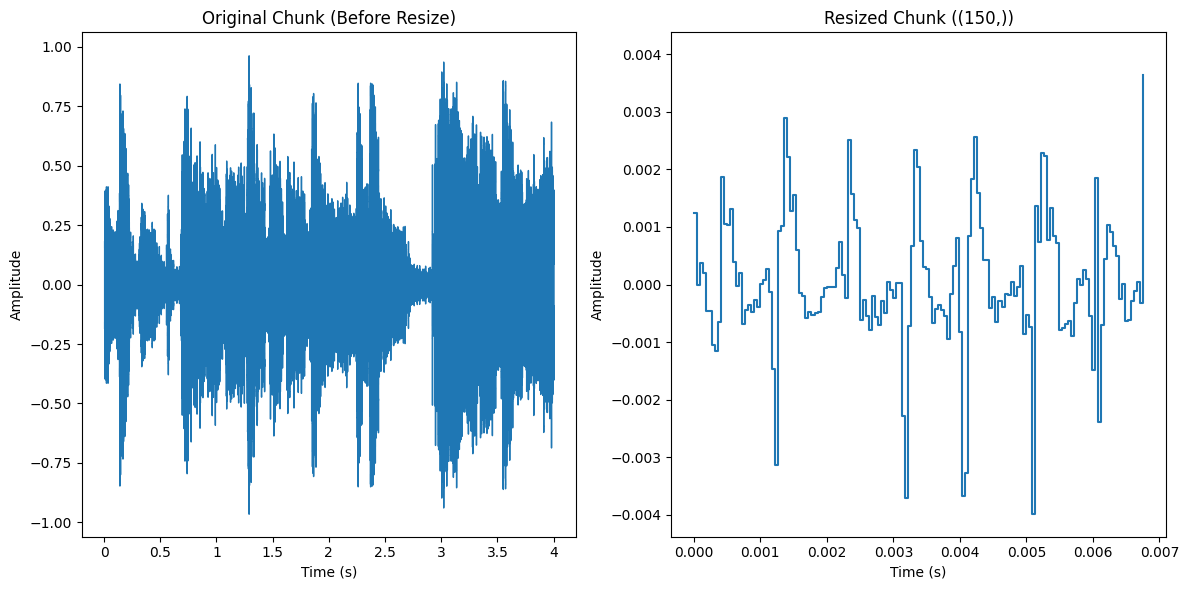


[INFO] Visualizing chunk 2/3 ...


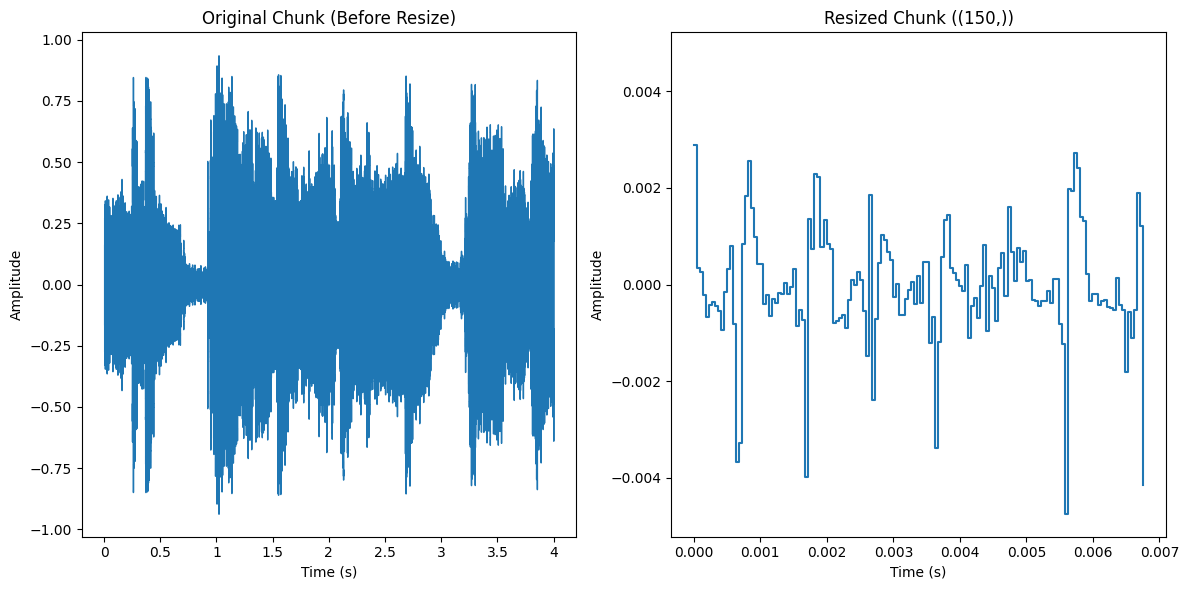


[INFO] Visualizing chunk 3/3 ...


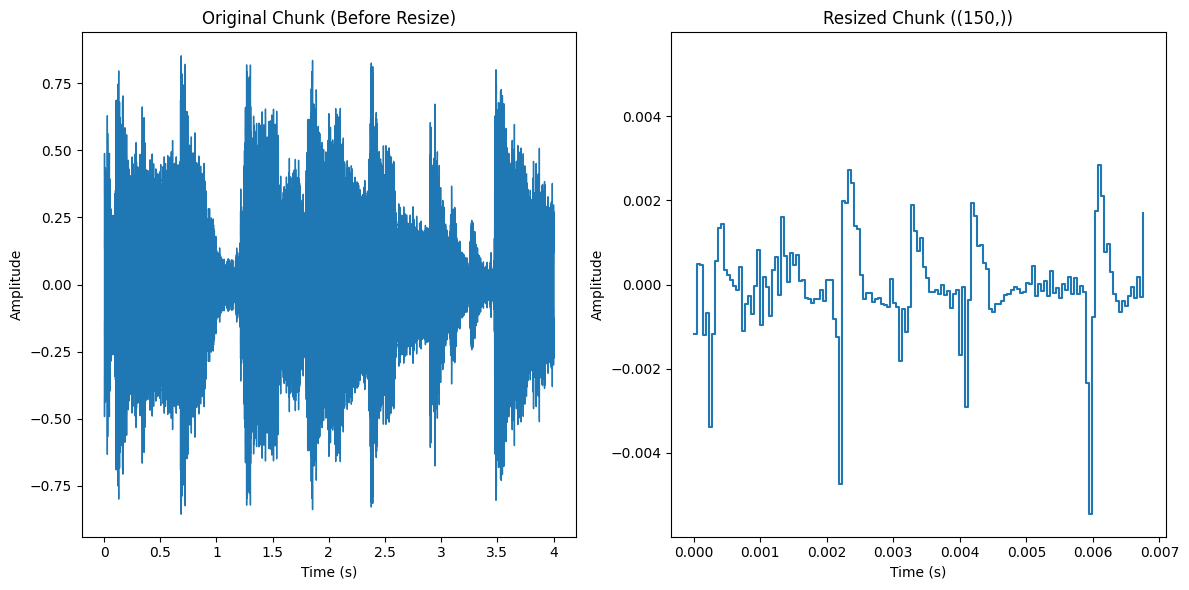

   -> Loading blues.00085.wav ... OK.  => Splitting into 15 chunks.
   -> Loading blues.00012.wav ... OK.  => Splitting into 15 chunks.
   -> Loading blues.00005.wav ... OK.  => Splitting into 14 chunks.
   -> Loading blues.00037.wav ... OK.  => Splitting into 14 chunks.
   -> Loading blues.00011.wav ... OK.  => Splitting into 15 chunks.
   -> Loading blues.00039.wav ... OK.  => Splitting into 15 chunks.
   -> Loading blues.00042.wav ... OK.  => Splitting into 15 chunks.
   -> Loading blues.00073.wav ... OK.  => Splitting into 15 chunks.
   -> Loading blues.00019.wav ... OK.  => Splitting into 15 chunks.
   -> Loading blues.00054.wav ... OK.  => Splitting into 15 chunks.
   -> Loading blues.00026.wav ... OK.  => Splitting into 14 chunks.
   -> Loading blues.00016.wav ... OK.  => Splitting into 15 chunks.
   -> Loading blues.00044.wav ... OK.  => Splitting into 15 chunks.
   -> Loading blues.00032.wav ... OK.  => Splitting into 15 chunks.
   -> Loading blues.00013.wav ... OK.  => Splitt

KeyboardInterrupt: 

In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from skimage.transform import resize

# تابع برای نمایش چانک قبل و بعد از ریسایز
def show_chunk_before_after_resize(chunk, sr, resize_shape):
    """
    نمایش چانک صوتی قبل و بعد از ریسایز کردن
    """
    plt.figure(figsize=(12, 6))

    # نمایش چانک اصلی (قبل از ریسایز)
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(chunk, sr=sr)
    plt.title("Original Chunk (Before Resize)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    # ریسایز چانک
    resized_chunk = resize(chunk, (resize_shape[0],), mode='constant', preserve_range=True)

    # نمایش چانک ریسایز شده
    plt.subplot(1, 2, 2)
    librosa.display.waveshow(resized_chunk.flatten(), sr=sr)
    plt.title(f"Resized Chunk ({resize_shape})")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    plt.tight_layout()
    plt.show()

# تابع برای بارگذاری و پردازش داده‌ها با نمایش چانک
def load_and_preprocess_data_with_visualization(
    data_dir,
    classes,
    chunk_duration=4.0,
    overlap_duration=2.0,
    sr=None,
    augmentation=False,
    trim_silence=False,
    top_db=20,
    verbose=True,
    visualize_chunks=3,  # تعداد چانک‌هایی که قرار است بصری‌سازی شوند
    resize_shape=(150,)  # شکل ریسایز چانک‌ها
):
    """
    این تابع تمام داده‌ها را پردازش کرده و چانک‌ها را قبل و بعد از ریسایز بصری‌سازی می‌کند.
    """
    data = []
    labels = []

    if verbose:
        print("[INFO] Loading dataset from:", data_dir)
        print(f"[INFO] Classes: {classes}")
        print(f"[INFO] chunk_duration={chunk_duration}s, overlap={overlap_duration}s")
        print(f"[INFO] augmentation={augmentation}, trim_silence={trim_silence}")

    visualized_count = 0

    for class_idx, class_name in enumerate(classes):
        class_folder = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_folder):
            print(f"[WARNING] Skip {class_folder}: not a directory.")
            continue

        if verbose:
            print(f"\n[INFO] Processing class: {class_name}")

        for file_name in os.listdir(class_folder):
            if not file_name.lower().endswith(".wav"):
                continue

            file_path = os.path.join(class_folder, file_name)
            if verbose:
                print(f"   -> Loading {file_name} ... ", end='')

            try:
                audio_data, sr_loaded = librosa.load(file_path, sr=sr)
            except Exception as e:
                print(f"\n[ERROR] Could not load file: {file_name}, error: {e}")
                continue

            if verbose:
                print("OK.", end=" ")

            # حذف سکوت (اختیاری)
            if trim_silence:
                trimmed_data, _ = librosa.effects.trim(audio_data, top_db=top_db)
                if len(trimmed_data) > 0:
                    audio_data = trimmed_data

            chunk_samples = int(chunk_duration * sr_loaded)
            overlap_samples = int(overlap_duration * sr_loaded)

            if len(audio_data) < chunk_samples:
                print(f"[WARNING] {file_name} is shorter than {chunk_samples} samples. Skipped.")
                continue

            num_chunks = int(np.ceil((len(audio_data) - chunk_samples) / (chunk_samples - overlap_samples))) + 1

            if verbose:
                print(f" => Splitting into {num_chunks} chunks.")

            for i_chunk in range(num_chunks):
                start = i_chunk * (chunk_samples - overlap_samples)
                end = start + chunk_samples
                chunk = audio_data[start:end]

                if len(chunk) < chunk_samples:
                    pad_size = chunk_samples - len(chunk)
                    chunk = np.pad(chunk, (0, pad_size), mode='constant')

                if visualized_count < visualize_chunks:
                    print(f"\n[INFO] Visualizing chunk {visualized_count + 1}/{visualize_chunks} ...")
                    show_chunk_before_after_resize(chunk, sr=sr_loaded, resize_shape=resize_shape)
                    visualized_count += 1

                data.append(chunk)
                labels.append(class_idx)

    data = np.array(data, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)

    if verbose:
        print("\n[INFO] Finished processing.")
        print(f"       Data shape : {data.shape}")
        print(f"       Labels shape : {labels.shape}")

    return data, labels


# بارگذاری و پردازش داده‌ها
data, labels = load_and_preprocess_data_with_visualization(
    data_dir=DATA_DIR,
    classes=CLASSES,
    chunk_duration=4.0,
    overlap_duration=2.0,
    sr=None,
    augmentation=False,
    trim_silence=True,
    top_db=20,
    verbose=True,
    visualize_chunks=3,
    resize_shape=(150,)  # اندازه ریسایز چانک‌ها
)